## 9.1 图像增广

1. 概念
    - 图像增广(image augmentation)技术通过对训练图像做一系列随机改变，来产生相似但又不同的训练样本，从而扩大训练数据集的规模
    - 也可理解为:随机改变训练样本可以降低模型对某些属性的依赖，从而提高模型的泛化能力
2. 举例
    - 可以对图像进行不同方式的裁剪，使感兴趣的物体出现在不同位置，从而减轻模型对物体出现位置的依赖性
    - 我们也可以调整亮度、色彩等因素来降低模型对色彩的敏感度

In [1]:
%matplotlib inline
import time
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image

import sys
sys.path.append("..") 
import d2lzh_pytorch.utils as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 9.1.1 常用的图像增广方法

In [2]:
d2l.set_figsize()
img = Image.open('../img/cat1.jpg')
#d2l.plt.imshow(img)

In [3]:
# 像素; num_rows * num_cols
def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j])
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

In [4]:
# 对输入图像img多次运行图像增广方法aug并展示所有的结果
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale)

#### 9.1.1.1 翻转和裁剪

通过`torchvision.transforms`创建`RandomHorizontalFlip`实例实现一般概率的图像水平(左右)翻转

```python
torchvision.transforms.RandomHorizontalFlip(p=0.5)
```
- p (float) – probability of the image being flipped. Default value is 0.5

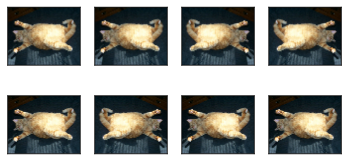

In [5]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

### 对图像随机裁剪来让物体以不同的比例出现在图像的不同位置，这同样能够降低模型对目标位置的敏感性


```python
torchvision.transforms.RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2)

```
- size – expected output size of each edge
- scale – range of size of the origin size cropped
- ratio – range of aspect ratio of the origin aspect ratio cropped
- interpolation – Default: PIL.Image.BILINEAR

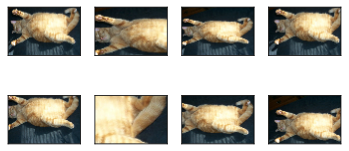

In [6]:
shape_aug = torchvision.transforms.RandomResizedCrop((200, 300), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

#### 9.1.1.2 变化颜色

- 亮度（brightness）
- 对比度（contrast）
- 饱和度（saturation）
- 色调（hue）

```python
torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)
```
- brightness(亮度)  How much to jitter brightness
- contrast(对比度) How much to jitter contrast.
- saturation(饱和度) How much to jitter saturation
- hue(色调)  How much to jitter hue

 从 [max(0, 1 - arg), 1 + arg],或 [min, max]. 均匀分布中随机获取

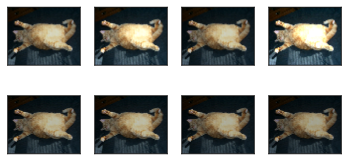

In [7]:
# 亮度
apply(img, torchvision.transforms.ColorJitter(brightness=0.5))

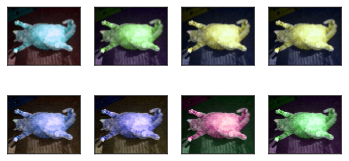

In [8]:
# 色调
apply(img, torchvision.transforms.ColorJitter(hue=0.5))

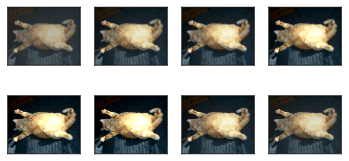

In [9]:
# 对比度
apply(img, torchvision.transforms.ColorJitter(contrast=0.5))

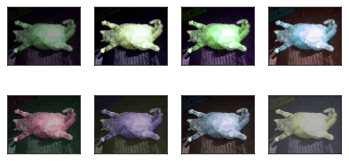

In [10]:
# 同时设置
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

#### 9.1.1.3 叠加多个图像增广方法

通过`Compose`实例将上面定义的多个图像增广方法叠加起来，再应用到每张图像之上

```
torchvision.transforms.Compose(transforms)
```

- transforms (list of Transform objects) – list of transforms to compose.

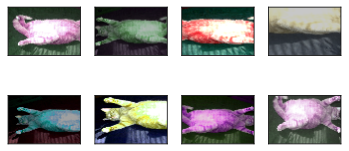

In [11]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

### 9.1.2 使用图像增广训练模型

为了在预测时得到确定的结果，我们通常只将图像增广应用在训练样本上，而不在预测时使用含随机操作的图像增广

Using downloaded and verified file: C:\Users\enmonster/Datasets/CIFAR\cifar-10-python.tar.gz
Extracting C:\Users\enmonster/Datasets/CIFAR\cifar-10-python.tar.gz to C:\Users\enmonster/Datasets/CIFAR


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025FA2846C50>,
      dtype=object)

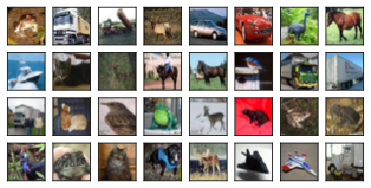

In [13]:
# 每个元素都是(image, label)
all_images = torchvision.datasets.CIFAR10(train=True, root='~/Datasets/CIFAR', download=True)
show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8)

**通常只将图像增广应用在训练样本上，而不在预测时使用含随机操作的图像增广**

```python
torchvision.transforms.ToTensor
```
> 将PIL图像或范围为[0，255]的numpy.ndarray（H x W x C）转换为形状为（批量大小, 通道数, 高, 宽）的Torch.FloatTensor，范围为[0.0，1.0]，如果PIL图像属于
或其中一种模式（L，LA，P，I，F，RGB，YCbCr，RGBA，CMYK，1）或numpy.ndarray具有dtype = np.uint8

In [14]:
# 左右随机翻转
flip_aug = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()
])

# 转换为pytorch所需数据格式,此处用于测试集,不对数据进行增广
no_aug = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

```
torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, num_workers=0, collate_fn=None, pin_memory=False, drop_last=False, timeout=0, worker_init_fn=None, multiprocessing_context=None)
```

**合并数据集和采样器，并在给定的数据集上提供可迭代的**

- dataset (Dataset) – 从中加载数据的数据集.
- batch_size (int, optional) – 每批次要装载多少样品 (default: 1).
- shuffle (bool, optional) – 设置为True以使数据在每个时期都重新洗改 (default: False).
- sampler (Sampler, optional) – 定义从数据集中抽取样本的策略。如果指定，则shuffle必须为False.
- batch_sampler (Sampler, optional) – 类似于采样器，但一次返回一批索引。与-batch_size，shuffle，sampler和drop_last互斥
- num_workers (int, optional) – 多少个子流程用于数据加载。0表示将在主进程中加载​​数据. (default: 0)
- collate_fn (callable, optional) – 合并样本列表以形成张量的小批量。在使用批处理时使用-从地图样式数据集中加载.
- pin_memory (bool, optional) – 如果为True，则数据加载器在将张量返回之前将其复制到CUDA固定的内存中。如果您的数据元素是自定义类型，或者您的collat​​e_fn返回的是自定义类型的批次
- drop_last (bool, optional) – 如果数据集大小不能被-批大小整除，则设置为True以删除最后一个不完整的批。如果为False并且数据集的大小不能被批次大小整除，那么最后一批将较小. (- default: False)
- timeout (numeric, optional) – 如果为正，则为从工作人员收集批次的超时值。应始终为-非负. (default: 0)
- worker_init_fn (callable, optional) – 如果不为None，则在种子创建后和数据加载之前，将在每个工作程序子进程上以工作程序ID（在[0，num_workers-1]中的-int）作为输入来调用此方法. (default: None)

In [16]:
num_workers = 0 if sys.platform.startswith('win32') else 4

def load_cifa10(is_train, augs, batch_size, root='~/Datasets/CIFAR'):
    dataset = torchvision.datasets.CIFAR10(root=root, train=is_train, transform=augs, download=True)
    return DataLoader(dataset, batch_size=batch_size, shuffle=is_train, num_workers=num_workers)


#### 9.1.2.1 使用图像增广训练模型

In [17]:
def train(train_iter, test_iter, net, loss, optimizer, device, num_epochs):
    net = net.to(device)
    batch_count = 0
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = d2l.evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))

In [18]:
def train_with_data_aug(train_augs, test_augs, lr=0.001):
    batch_size, net = 256, d2l.resnet18(10)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = torch.nn.CrossEntropyLoss()
    train_iter = load_cifa10(True, train_augs, batch_size)
    test_iter = load_cifa10(False, test_augs, batch_size)
    train(train_iter, test_iter, net, loss, optimizer, device, num_epochs=10)

In [19]:
train_with_data_aug(flip_aug, no_aug)

Files already downloaded and verified
Files already downloaded and verified
epoch 1, loss 1.3955, train acc 0.498, test acc 0.562, time 599.7 sec
epoch 2, loss 0.5043, train acc 0.644, test acc 0.595, time 575.1 sec
epoch 3, loss 0.2839, train acc 0.698, test acc 0.653, time 571.3 sec
epoch 4, loss 0.1854, train acc 0.741, test acc 0.675, time 841.8 sec
epoch 5, loss 0.1342, train acc 0.766, test acc 0.705, time 571.1 sec
epoch 6, loss 0.1008, train acc 0.790, test acc 0.732, time 569.6 sec
epoch 7, loss 0.0800, train acc 0.807, test acc 0.655, time 568.9 sec
epoch 8, loss 0.0636, train acc 0.824, test acc 0.730, time 569.0 sec
epoch 9, loss 0.0515, train acc 0.839, test acc 0.721, time 571.0 sec
epoch 10, loss 0.0429, train acc 0.851, test acc 0.766, time 584.8 sec
